In [17]:
import json

import mlflow.prophet
import itertools
import numpy as np
import pandas as pd
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient
from prophet import Prophet, serialize
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly


In [24]:
import pandas as pd
import yfinance as yf


class GasPrices:
    """
    Makes use of the yfinance python module
    to scrape natural gas prices from the TTF market.
    """

    # def __init__(self) -> None:
    #     pass

    def get_data() -> pd.DataFrame:
        symbol = "TTF=F"
        ticker = yf.Ticker(symbol)
        gas_prices = ticker.history(
            interval="1wk",
            start="2005-01-01",
            end=None,
            actions=True,
            auto_adjust=True,
            back_adjust=False,
        )

        gas_prices.index = pd.to_datetime(gas_prices.index)
        gas_prices.index = gas_prices.index.date
        gas_prices = gas_prices[["Close"]]
        gas_prices = gas_prices.rename(columns={"Close": "GAS NATURALE"})

        return gas_prices

### With Logistic Growth and lower bound to 0

In [97]:
class Forecaster():
    def __init__(self) -> None:
        pass    

    def extract_params(self, pr_model):
        return {attr: getattr(pr_model, attr) for attr in serialize.SIMPLE_ATTRIBUTES}

    def train_model(
            self,
            experiment_name: str, 
            train_df: pd.DataFrame, 
            target_col: str,
            date_col: str = "index", 
            horizon: str="28 days",
            period: str="14 days",
            initial: str="1680 days", 
            artifact_path: str="prophet", 
            metrics: list=["mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"], 
            time_series_params: dict={
                'changepoint_range': 0.8,
                'changepoint_prior_scale': 0.5, 
                'seasonality_prior_scale': 0.1, 
                'seasonality_mode': 'multiplicative'
                }
        ) -> str:
            """
            Trains an instance of the Prophet model on a given DataFrame and tracks 
            the experiment with Mlflow. Prophet model accepts only a column `y` with
            the target variable and a column `ds` with the dates, so we preprocess
            the training df before fitting it. 
            
            Args
            ---------
            train_df: pd.DataFrame
                the training data for the model.
            target_col: str
                the time-series target column
            date_col: str
                the column holding the time informations on the series
            artifact_path: str
                the path pointing to the MLflow artifact
            metrics: list:
                list of the metrics to track in the mlflow experiment run.
            
            Returns
            --------
            model_uri: str
                the model uri to load the prophet model directly from mlflow
            """
            self.train_df = train_df
            self.date_col = date_col
            self.target_col = target_col
            
            if self.date_col == "index":
                self.train_df.reset_index(inplace=True)
                self.train_df = train_df.rename(columns={self.date_col:"ds", self.target_col:"y"})

            else: 
                self.train_df = self.train_df.rename(columns={date_col:"ds", target_col:"y"})

            self.train_df["cap"] = 10000
            self.train_df["floor"] = 0
            mlflow.set_experiment(experiment_name=experiment_name)
            with mlflow.start_run():
                
                model = Prophet(
                    growth="logistic",
                    changepoint_range=time_series_params["changepoint_range"],
                    changepoint_prior_scale=time_series_params["changepoint_prior_scale"],
                    seasonality_prior_scale=time_series_params["seasonality_prior_scale"],
                    seasonality_mode=time_series_params["seasonality_mode"]
                    ).fit(self.train_df)

                params = self.extract_params(model)

                metrics_raw = cross_validation(
                    model=model,
                    horizon=horizon,
                    period=period,
                    initial=initial,
                    parallel="processes",
                    disable_tqdm=True,
                )
                cv_metrics = performance_metrics(metrics_raw)
                metrics_dict = {k: cv_metrics[k].mean() for k in metrics}

                print(f"Logged Metrics: \n{json.dumps(metrics_dict, indent=2)}")
                print(f"Logged Params: \n{json.dumps(params, indent=2)}")

                train = model.history
                future = model.make_future_dataframe(
                    periods=10,
                    freq=pd.infer_freq(self.train_df["ds"])
                )
                future["cap"] = 10000
                future["floor"] = 0
                predictions = model.predict(future)
                signature = infer_signature(train, predictions)

                mlflow.prophet.log_model(
                    model, 
                    artifact_path=artifact_path, 
                    signature=signature
                )
                mlflow.log_params(params)
                mlflow.log_metrics(metrics_dict)
                self.model_uri = mlflow.get_artifact_uri(artifact_path)
            
            self.model = model # to use outside of mlflow

            return self.model_uri
    
    def forecast(
            self, 
            n_steps: int=0, 
            keep_in_sample_forecast: bool=True,
            model_uri: str = None
        ) -> pd.DataFrame:
        """
        Use the trained model to predict into the future. \n
        The user can predict only on the training data horizon (in-sample forecast) 
        and also forecast into the future, specifying how many steps ahead with 
        the param `n_steps` (out-of-sample forecast).

        Args:
        ----------
        n_steps: int
            the number of steps (1 step is one skip in the frequency of the training set)
            into the future you want to obtain a forecast for. \n
            When set to 0, we are only predicting in-sample.
        keep_in_sample_forecast: bool
            wether or not to keep the predictions made on the test set 
        """
        
        if not model_uri: # use the model nested in the forecaster class
        
            future = self.model.make_future_dataframe(
                periods=n_steps,
                freq=pd.infer_freq(self.train_df["ds"]),
                include_history=True
            )
            future["cap"] = 10000
            future["floor"] = 0
            predictions = self.model.predict(future)

        else: # use the model logged into mlflow
            loaded_model = mlflow.prophet.load_model(model_uri)

            future = loaded_model.make_future_dataframe(
                periods=n_steps,
                freq=pd.infer_freq(self.train_df["ds"]),
                include_history=True
            )
            future["cap"] = 10000
            future["floor"] = 0
            predictions = loaded_model.predict(future)

        if not keep_in_sample_forecast:
            predictions = predictions.tail(n_steps)

        return predictions

In [98]:
gas_prices = GasPrices.get_data()
gas_prices

,GAS NATURALE
2017-10-23,18.150000
2017-10-30,18.309999
2017-11-06,19.820000
2017-11-13,18.950001
2017-11-20,20.455000
...,...
2023-07-31,28.853001
2023-08-07,35.299999
2023-08-14,36.410000
2023-08-21,34.777000


In [99]:
forecaster = Forecaster()

forecaster.train_model(train_df=gas_prices, target_col="GAS NATURALE", experiment_name="gas_model")


17:13:40 - cmdstanpy - INFO - Chain [1] start processing
17:13:40 - cmdstanpy - INFO - Chain [1] done processing
17:13:41 - cmdstanpy - INFO - Chain [1] start processing
17:13:41 - cmdstanpy - INFO - Chain [1] start processing
17:13:41 - cmdstanpy - INFO - Chain [1] done processing
17:13:41 - cmdstanpy - INFO - Chain [1] start processing
17:13:41 - cmdstanpy - INFO - Chain [1] start processing
17:13:41 - cmdstanpy - INFO - Chain [1] done processing
17:13:41 - cmdstanpy - INFO - Chain [1] start processing
17:13:41 - cmdstanpy - INFO - Chain [1] start processing
17:13:41 - cmdstanpy - INFO - Chain [1] done processing
17:13:41 - cmdstanpy - INFO - Chain [1] done processing
17:13:41 - cmdstanpy - INFO - Chain [1] start processing
17:13:41 - cmdstanpy - INFO - Chain [1] done processing
17:13:41 - cmdstanpy - INFO - Chain [1] start processing
17:13:41 - cmdstanpy - INFO - Chain [1] start processing
17:13:41 - cmdstanpy - INFO - Chain [1] done processing
17:13:41 - cmdstanpy - INFO - Chain [1

Logged Metrics: 
{
  "mse": 7949.079412855617,
  "rmse": 88.46266778874404,
  "mae": 62.98997525141155,
  "mape": 0.6781600367056955,
  "mdape": 0.6858492802810144,
  "smape": 0.8576516771352745,
  "coverage": 0.29838709677419356
}
Logged Params: 
{
  "growth": "logistic",
  "n_changepoints": 25,
  "specified_changepoints": false,
  "changepoint_range": 0.8,
  "yearly_seasonality": "auto",
  "weekly_seasonality": "auto",
  "daily_seasonality": "auto",
  "seasonality_mode": "multiplicative",
  "seasonality_prior_scale": 0.1,
  "changepoint_prior_scale": 0.5,
  "holidays_prior_scale": 10.0,
  "mcmc_samples": 0,
  "interval_width": 0.8,
  "uncertainty_samples": 1000,
  "y_scale": 339.1960144042969,
  "logistic_floor": true,
  "country_holidays": null,
  "component_modes": {
    "additive": [
      "additive_terms",
      "extra_regressors_additive"
    ],
    "multiplicative": [
      "yearly",
      "multiplicative_terms",
      "extra_regressors_multiplicative",
      "holidays"
    ]
 

/Users/dylantartarini/miniconda3/envs/epm/lib/python3.9/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/Users/dylantartarini/miniconda3/envs/epm/lib/python3.9/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python c

'file:///Users/dylantartarini/Desktop/energy_prices_monitoring_ita/notebooks/mlruns/558597933651515027/486a8af4319d4bf6a45378bbf8498797/artifacts/prophet'

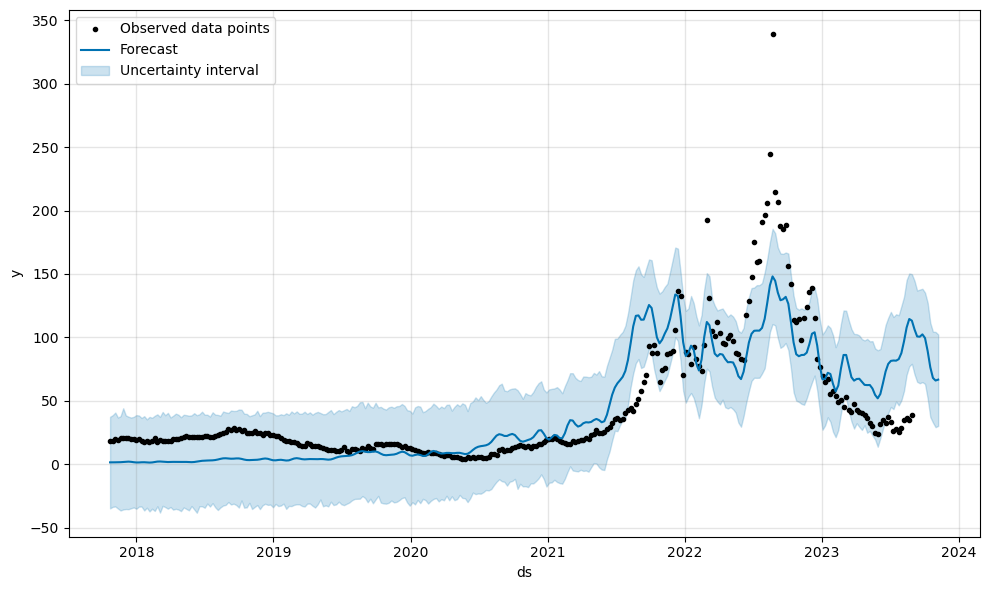

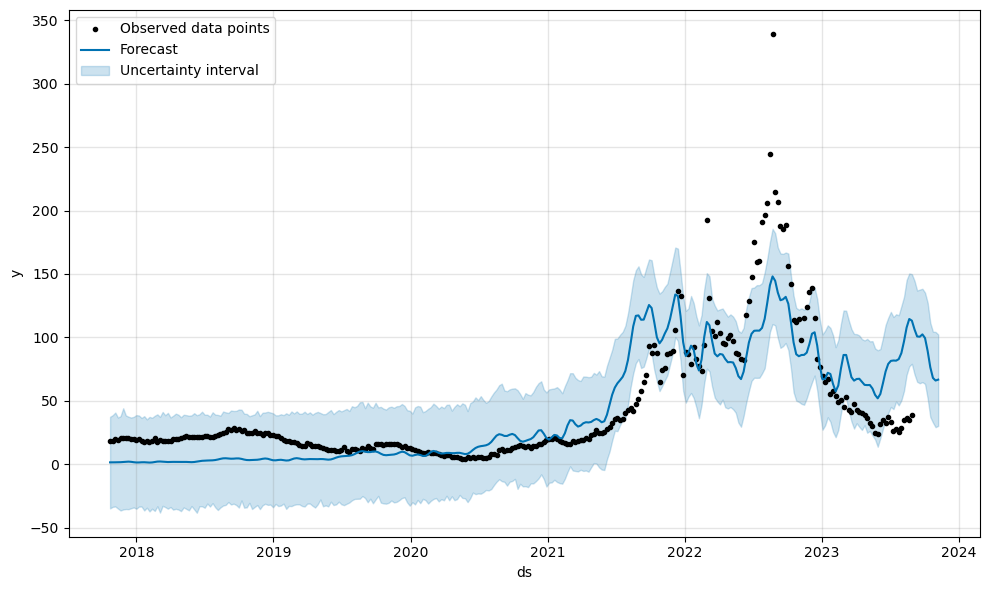

In [96]:
fcst = forecaster.forecast(n_steps=10)
forecaster.model.plot(fcst, plot_cap=False, include_legend=True)

### With Linear Growth and no lower bound

In [100]:
class Forecaster():
    def __init__(self) -> None:
        pass    

    def extract_params(self, pr_model):
        return {attr: getattr(pr_model, attr) for attr in serialize.SIMPLE_ATTRIBUTES}

    def train_model(
            self,
            experiment_name: str, 
            train_df: pd.DataFrame, 
            target_col: str,
            date_col: str = "index", 
            horizon: str="28 days",
            period: str="14 days",
            initial: str="1680 days", 
            artifact_path: str="prophet", 
            metrics: list=["mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"], 
            time_series_params: dict={
                'changepoint_range': 0.7,
                'changepoint_prior_scale': 0.5, 
                'seasonality_prior_scale': 0.1, 
                'seasonality_mode': 'multiplicative'
                }
        ) -> str:
            """
            Trains an instance of the Prophet model on a given DataFrame and tracks 
            the experiment with Mlflow. Prophet model accepts only a column `y` with
            the target variable and a column `ds` with the dates, so we preprocess
            the training df before fitting it. 
            
            Args
            ---------
            `train_df`: `pd.DataFrame`
                the training data for the model.
            `target_col`: `str`
                the time-series target column
            `date_col`: `str`
                the column holding the time informations on the series
            `horizon`: `str`
                it's the horizon interval of each prediction performed during training 
            `period`: `str`
                it's the frequency of predictions performed during training
            `initial`: `str`
                the initial training set
            `artifact_path`: `str`
                the path pointing to the MLflow artifact
            `metrics`: `list`:
                list of the metrics to track in the mlflow experiment run.
            `time_series_params`: `dict`
                dictionary of parameters that can be used to configure the Prophet model.
            
            Returns
            --------
            `model_uri`: `str`
                the model uri to load the prophet model directly from MLflow
            """
            self.train_df = train_df
            self.date_col = date_col
            self.target_col = target_col
            
            if self.date_col == "index":
                self.train_df.reset_index(inplace=True)
                self.train_df = train_df.rename(columns={self.date_col:"ds", self.target_col:"y"})

            else: 
                self.train_df = self.train_df.rename(columns={date_col:"ds", target_col:"y"})

            mlflow.set_experiment(experiment_name=experiment_name)
            with mlflow.start_run():
                
                model = Prophet(
                    changepoint_range=time_series_params["changepoint_range"],
                    changepoint_prior_scale=time_series_params["changepoint_prior_scale"],
                    seasonality_prior_scale=time_series_params["seasonality_prior_scale"],
                    seasonality_mode=time_series_params["seasonality_mode"]
                    ).fit(self.train_df)

                params = self.extract_params(model)

                metrics_raw = cross_validation(
                    model=model,
                    horizon=horizon,
                    period=period,
                    initial=initial,
                    parallel="processes",
                    disable_tqdm=True,
                )
                cv_metrics = performance_metrics(metrics_raw)
                metrics_dict = {k: cv_metrics[k].mean() for k in metrics}

                print(f"Logged Metrics: \n{json.dumps(metrics_dict, indent=2)}")
                print(f"Logged Params: \n{json.dumps(params, indent=2)}")

                train = model.history
                future = model.make_future_dataframe(
                    periods=10,
                    freq=pd.infer_freq(self.train_df["ds"])
                )
                predictions = model.predict(future)
                signature = infer_signature(train, predictions)

                mlflow.prophet.log_model(
                    model, 
                    artifact_path=artifact_path, 
                    signature=signature
                )
                mlflow.log_params(params)
                mlflow.log_metrics(metrics_dict)
                self.model_uri = mlflow.get_artifact_uri(artifact_path)
            
            self.model = model # to use outside of mlflow

            return self.model_uri
    
    def forecast(
            self, 
            n_steps: int=0, 
            keep_in_sample_forecast: bool=True,
            model_uri: str = None
        ) -> pd.DataFrame:
        """
        Use the trained model to predict into the future. \n
        The user can predict only on the training data horizon (in-sample forecast) 
        and also forecast into the future, specifying how many steps ahead with 
        the param `n_steps` (out-of-sample forecast).

        Args:
        ----------
        n_steps: int
            the number of steps (1 step is one skip in the frequency of the training set)
            into the future you want to obtain a forecast for. \n
            When set to 0, we are only predicting in-sample.
        keep_in_sample_forecast: bool
            wether or not to keep the predictions made on the test set 
        """
        
        if not model_uri: # use the model nested in the forecaster class
        
            future = self.model.make_future_dataframe(
                periods=n_steps,
                freq=pd.infer_freq(self.train_df["ds"]),
                include_history=True
            )
            predictions = self.model.predict(future)

        else: # use the model logged into mlflow
            loaded_model = mlflow.prophet.load_model(model_uri)

            future = loaded_model.make_future_dataframe(
                periods=n_steps,
                freq=pd.infer_freq(self.train_df["ds"]),
                include_history=True
            )
            predictions = loaded_model.predict(future)

        if not keep_in_sample_forecast:
            predictions = predictions.tail(n_steps)

        return predictions

In [101]:
gas_prices = GasPrices.get_data()

forecaster = Forecaster()

forecaster.train_model(train_df=gas_prices, target_col="GAS NATURALE", experiment_name="gas_model")

17:18:15 - cmdstanpy - INFO - Chain [1] start processing
17:18:15 - cmdstanpy - INFO - Chain [1] done processing
17:18:15 - cmdstanpy - INFO - Chain [1] start processing
17:18:15 - cmdstanpy - INFO - Chain [1] done processing
17:18:16 - cmdstanpy - INFO - Chain [1] start processing
17:18:16 - cmdstanpy - INFO - Chain [1] start processing
17:18:16 - cmdstanpy - INFO - Chain [1] start processing
17:18:16 - cmdstanpy - INFO - Chain [1] start processing
17:18:16 - cmdstanpy - INFO - Chain [1] start processing
17:18:16 - cmdstanpy - INFO - Chain [1] done processing
17:18:16 - cmdstanpy - INFO - Chain [1] done processing
17:18:16 - cmdstanpy - INFO - Chain [1] start processing
17:18:16 - cmdstanpy - INFO - Chain [1] done processing
17:18:16 - cmdstanpy - INFO - Chain [1] start processing
17:18:16 - cmdstanpy - INFO - Chain [1] start processing
17:18:16 - cmdstanpy - INFO - Chain [1] start processing
17:18:16 - cmdstanpy - INFO - Chain [1] done processing
17:18:16 - cmdstanpy - INFO - Chain [

Logged Metrics: 
{
  "mse": 11920.393624373564,
  "rmse": 107.40130607942226,
  "mae": 100.14006365521605,
  "mape": 1.9516293282297852,
  "mdape": 1.7487129379352502,
  "smape": 0.8540609816299184,
  "coverage": 0.008064516129032258
}
Logged Params: 
{
  "growth": "linear",
  "n_changepoints": 25,
  "specified_changepoints": false,
  "changepoint_range": 0.7,
  "yearly_seasonality": "auto",
  "weekly_seasonality": "auto",
  "daily_seasonality": "auto",
  "seasonality_mode": "multiplicative",
  "seasonality_prior_scale": 0.1,
  "changepoint_prior_scale": 0.5,
  "holidays_prior_scale": 10.0,
  "mcmc_samples": 0,
  "interval_width": 0.8,
  "uncertainty_samples": 1000,
  "y_scale": 339.1960144042969,
  "logistic_floor": false,
  "country_holidays": null,
  "component_modes": {
    "additive": [
      "additive_terms",
      "extra_regressors_additive"
    ],
    "multiplicative": [
      "yearly",
      "multiplicative_terms",
      "extra_regressors_multiplicative",
      "holidays"
    

'file:///Users/dylantartarini/Desktop/energy_prices_monitoring_ita/notebooks/mlruns/558597933651515027/d995456148b8467cab42e3b6ec98326d/artifacts/prophet'

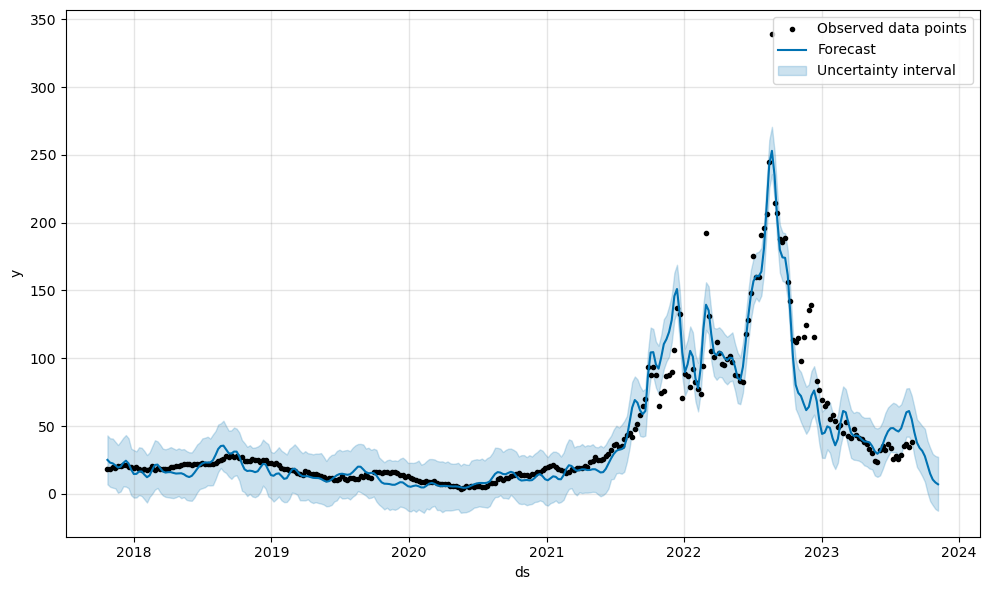

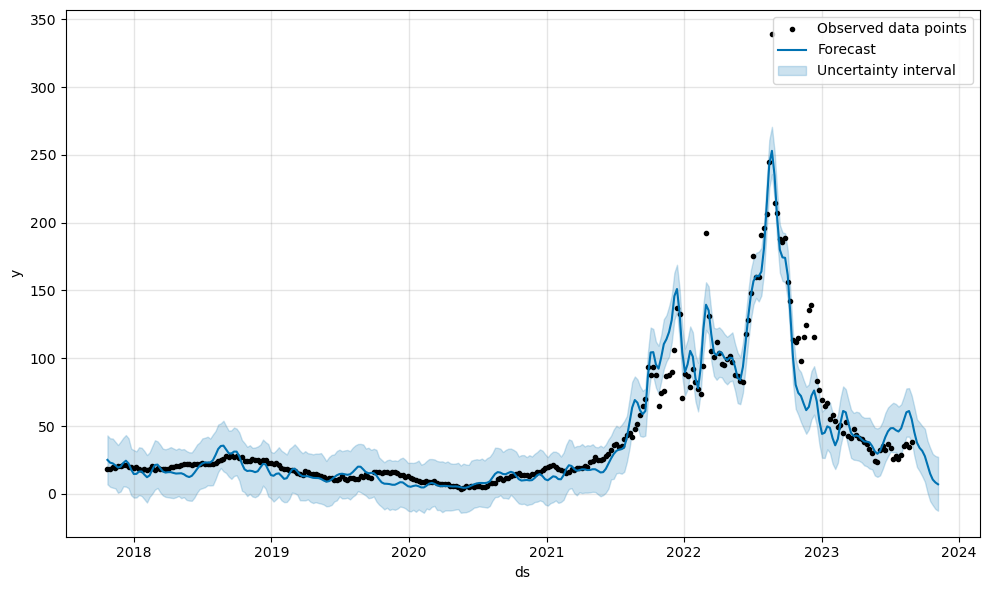

In [102]:
fcst = forecaster.forecast(n_steps=10)
forecaster.model.plot(fcst, plot_cap=False, include_legend=True)

### Hyperparameter Tuning


In [70]:
gas_prices

,GAS NATURALE
2017-10-23,18.150000
2017-10-30,18.309999
2017-11-06,19.820000
2017-11-13,18.950001
2017-11-20,20.455000
...,...
2023-07-31,28.853001
2023-08-07,35.299999
2023-08-14,36.410000
2023-08-21,34.777000


In [71]:
train_df = gas_prices
train_df.reset_index(inplace=True)
train_df = train_df.rename(columns={"index":"ds", "GAS NATURALE":"y"})


In [72]:
train_df.head()

,ds,y
0,2017-10-23,18.150000
1,2017-10-30,18.309999
2,2017-11-06,19.820000
3,2017-11-13,18.950001
4,2017-11-20,20.455000


In [73]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    # 'changepoint_range': [0.7, 0.75, 0.8, 0.85, 0.9] # this decides when to stop fitting the trend (avoid overiftting in the last 30%, 25%, 20% of data?)

}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_df)  # Fit model with given params
    df_cv = cross_validation(m, horizon="28 days", period="7 days", parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

ValueError: Capacities must be supplied for logistic growth in column "cap"

In [37]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}
